In [1]:
using Lale

┌ Info: Precompiling Lale [25676c37-aa2f-4f14-ad5b-b63670ababff]
└ @ Base loading.jl:1317


In [2]:
using Random
using Statistics
using Test
using DataFrames: DataFrame
using AutoMLPipeline: Utils

In [3]:
iris = getiris();
#TODO: train-test split

## AutoML for classifier pipeline

This example uses Lale for combined algorithm selection and hyperparameter tuning
on a classifier pipeline.

In [4]:
clf_X = iris[:,1:4] |> DataFrame
clf_y = iris[:,5]   |> Vector;

In [5]:
PCA = laleoperator("PCA")
RobustScaler = laleoperator("RobustScaler")
ConcatFeatures = laleoperator("ConcatFeatures", "lale")
LogisticRegression = laleoperator("LogisticRegression")
RandomForestClassifier = laleoperator("RandomForestClassifier");

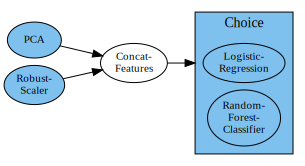

In [6]:
clf_planned = (PCA & RobustScaler) >> ConcatFeatures >> (LogisticRegression | RandomForestClassifier);
visualize(clf_planned)

100%|███████| 10/10 [00:07<00:00,  1.25trial/s, best loss: -0.9666666666666667]

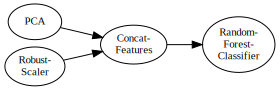

In [7]:
clf_hopt = LalePipeOptimizer(clf_planned, max_evals=10, cv=3)
clf_trained = fit(clf_hopt, clf_X, clf_y);
visualize(clf_trained)

In [8]:
#TODO: change to predict, not transform
clf_pred = transform(clf_trained, clf_X)
clf_accu = score(:accuracy, clf_pred, clf_y)

98.66666666666667

## AutoML for regressor pipeline

This example uses Lale for combined algorithm selection and hyperparameter tuning
on a regressor pipeline.

In [9]:
reg_X = iris[:,1:3] |> DataFrame
reg_y = iris[:,4]   |> Vector;

In [10]:
PCA = laleoperator("PCA")
NoOp = laleoperator("NoOp", "lale")
LinearRegression = laleoperator("LinearRegression")
RandomForestRegressor = laleoperator("RandomForestRegressor");

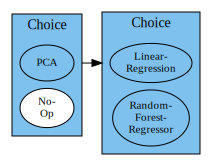

In [11]:
reg_planned = (PCA | NoOp) >> (LinearRegression | RandomForestRegressor);
visualize(reg_planned)


100%|████████| 10/10 [00:04<00:00,  2.11trial/s, best loss: 0.6099374987699129]

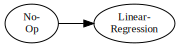

In [12]:
reg_hopt = LalePipeOptimizer(reg_planned, max_evals=10, cv=3)
reg_trained = fit(reg_hopt, reg_X, reg_y);
visualize(reg_trained)

In [13]:
#TODO: change to predict, not transform
reg_pred = transform(reg_trained, reg_X)
reg_rmse = score(:rmse, reg_pred, reg_y)

0.1905638165002068

## Other stuff

In [14]:
PCA |> typeof |> supertypes

(LaleOp, Lale.LaleAbsTypes.LaleOperator, Learner, Computer, Machine, Any)

In [15]:
RandomForestRegressor |> typeof |> supertypes

(LaleOp, Lale.LaleAbsTypes.LaleOperator, Learner, Computer, Machine, Any)

In [16]:
reg_hopt |> typeof |> supertypes

(LalePipeOptimizer, Lale.LaleAbsTypes.LaleOperator, Learner, Computer, Machine, Any)

In [17]:
# regression using AMLP pipeline
amlpipe = @pipeline  (PCA + NoOp) |> (RandomForestRegressor * LinearRegression)
amlpred = fit_transform!(amlpipe, reg_X, reg_y)
crossvalidate(amlpipe, reg_X, reg_y, "mean_squared_error")
amlprmse = score(:rmse, amlpred, reg_y)

fold: 1, 0.050740617249433045
fold: 2, 0.02823935187037022
fold: 3, 0.028248457777777784
fold: 4, 0.027225108518518674
fold: 5, 0.04295237844444445
fold: 6, 0.06245086034138995
fold: 7, 0.029861410666666924
fold: 8, 0.0249059573658352
fold: 9, 0.06287911164814851
fold: 10, 0.028986455294406698
errors: 0


0.0723019032333858

In [18]:
amlpipe |> typeof |> supertypes

(Pipeline, Workflow, Machine, Any)

In [19]:
# classification using AMLP pipeline
amlpipe = @pipeline  (PCA + RobustScaler) |> RandomForestClassifier
amlpred = fit_transform!(amlpipe, clf_X, clf_y)
crossvalidate(amlpipe, clf_X, clf_y, "accuracy_score")
amlpacc = score(:accuracy, amlpred, clf_y)

fold: 1, 0.8666666666666667
fold: 2, 1.0
fold: 3, 1.0
fold: 4, 1.0
fold: 5, 1.0
fold: 6, 0.9333333333333333
fold: 7, 1.0
fold: 8, 0.8
fold: 9, 0.8666666666666667
fold: 10, 1.0
errors: 0


100.0

In [20]:
# amlp ops
ohe  = OneHotEncoder()
catf = CatFeatureSelector()
numf = NumFeatureSelector();
#TODO: use Lale OneHotEncoder and Lale Project operators

In [21]:
plr = @pipeline (catf |> ohe) + (numf |> RobustScaler |> PCA) |> RandomForestRegressor;
crossvalidate(plr, reg_X, reg_y, "mean_absolute_error", 10, false) 

(mean = 0.14606404761904757, std = 0.02962023430616152, folds = 10, errors = 0)

In [22]:
plc = @pipeline (catf |> ohe) + (numf |> RobustScaler |> PCA) |> RandomForestClassifier;
crossvalidate(plc, clf_X, clf_y,"accuracy_score",10,false) 

(mean = 0.9533333333333334, std = 0.032203059435976525, folds = 10, errors = 0)